# 3. Creating an image classifier

A classic machine learning task is to train a model to classify images. Over the next few weeks, you will go through the basic steps in the machine learning pipeline that you will need to build more complex models:
1. Data handling
2. Using Pytorch (a machine learning framework) to define models
3. Create a training loop
4. Metric logging
5. Pytorch Lightning

For this exercise, we will be training a neural network to identify the digits 0 - 9 from pictures of handwritten numbers. In other words, given a picture of a digit such as this:  
<img style="float: left;" src="img/seven.png"/> 
<br clear="left"/>
Our model should be able to predict that this is the digit 7. Even relatively simple models (such as the one we will be building) can achieve very good results, as we will see.

## 3.1 Pytorch
Pytorch is a framework that provides many convenience functions and classes that will help us build our machine learning network much faster than we would be able to from scratch using pure Python. It takes care of abstracting away the components of your neural network (called `Module`s) and making sure that things like forward and backwards passes, gradient calculations, and weight updates are handled for you. It also facilitates the loading of data via classes like `Dataset` and `Dataloader`.



In [8]:
import torch

### 3.1.1  The MNIST dataset
The starting point of any machine learning project is the data. We need to ensure that we have a suitable dataset for the task at hand, and we need to do some work in order to prepare it before it is eventually put into our model. The dataset we will be using for our number recognition task is the popular [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which contains tens of thousands of images of digits written by different people and nicely formatted into a standard size (28 * 28 pixels).  

Let's download this dataset using the special `!` operator that we saw in last week's lab 

In [9]:
mnist_url = ''

# download mnist dataset and place in current directory
 

In [10]:
# extract contents
!tar -vxzf data/MNIST/raw.tar.gz -C data/MNIST 



raw/
raw/0/
raw/0/img_25792.jpg
raw/0/img_23907.jpg
raw/0/img_3259.jpg
raw/0/img_2943.jpg
raw/0/img_34904.jpg
raw/0/img_31977.jpg
raw/0/img_4573.jpg
raw/0/img_12315.jpg
raw/0/img_22262.jpg
raw/0/img_9624.jpg
raw/0/img_12885.jpg
raw/0/img_27184.jpg
raw/0/img_25657.jpg
raw/0/img_25884.jpg
raw/0/img_5560.jpg
raw/0/img_24203.jpg
raw/0/img_25068.jpg
raw/0/img_29565.jpg
raw/0/img_21433.jpg
raw/0/img_404.jpg
raw/0/img_797.jpg
raw/0/img_40927.jpg
raw/0/img_23149.jpg
raw/0/img_29542.jpg
raw/0/img_17189.jpg
raw/0/img_24691.jpg
raw/0/img_36710.jpg
raw/0/img_6902.jpg
raw/0/img_18925.jpg
raw/0/img_31798.jpg
raw/0/img_36626.jpg
raw/0/img_13027.jpg
raw/0/img_4908.jpg
raw/0/img_23891.jpg
raw/0/img_14949.jpg
raw/0/img_29101.jpg
raw/0/img_11576.jpg
raw/0/img_33478.jpg
raw/0/img_26396.jpg
raw/0/img_12427.jpg
raw/0/img_15005.jpg
raw/0/img_10156.jpg
raw/0/img_36633.jpg
raw/0/img_16783.jpg
raw/0/img_30069.jpg
raw/0/img_30353.jpg
raw/0/img_30035.jpg
raw/0/img_36642.jpg
raw/0/img_5306.jpg
raw/0/img_2385.jpg
r

In [ ]:
# create a csv file that maps images to their labels
!chmod +x data/MNIST/create_csv.sh && ./data/MNIST/create_csv.sh ./data/MNIST/raw

mapping files in directory: ./data/MNIST/raw
0: 4132
1: 4684
2: 4177
3: 4351
4: 4072
5: 3795
6: 4137
7: 4401
8: 4063
9: 4188


### 3.1.2 Visualising Images
When working with image data, it can be helpful to define visualisation helper functions to make sure that the data visually "looks right"

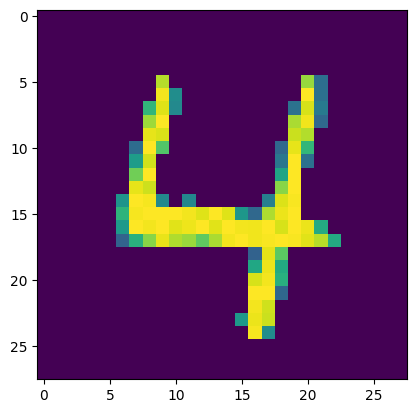

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


# Show validation batch with title "Val images"
...
# Show test batch with title "Test images"
...
def load_image_tensor(filepath, threshold):
    img = Image.open(filepath)
    transform = transforms.PILToTensor()
    img_tensor = transform(img)
    img_tensor = torch.where(img_tensor < threshold, 0, img_tensor)
    return img_tensor

img = load_image_tensor("data/MNIST/raw/4/img_42.jpg", 80).reshape(28, 28)
plt.imshow(img)


### 3.1.2 Subclassing the Dataset class
Dataset is an abstract class provided by Pytorch, which means it defines a specification of what its subclasses must look like via function signatures. However, these functions are not actually implemented in the source code of the Dataset class. It's the programmer's job (yours!) to make sure the methods laid out in the signatures are implemented. Let's import these modules now, along with some other useful packages. 

In [12]:
from torch.utils.data import Dataset
import pandas as pd

In [13]:
# Here we define our dataset - it is a map-style dataset, which means we have to know its size at initialisation and  
# must be able to access data points at arbitrary locations. This is why the following methods must be implemented:
# __len__ and __getitem__ 
class MNISTDataset(Dataset):
    def __init__(self, filepath: str): 
        super().__init__()
        # Load data from CSV filepath defined earlier into a Pandas dataframe
        self.dataset = pd.read_csv(filepath)
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset.iloc[index]

### 3.1.3 The collate function
The collate function is used to tell the Pytorch DataLoader how to handle datapoints from the MNISTDataset we defined earlier and pack them into a batch. By default (i.e. no specific collate_fn is passed), the DataLoader would simply add the dataset items to an array and ensure that the array is of a certain size (the batch size). This would normally not be a problem if we were working with text data that is of a fixed length.  

However, in our case, we are working with image data, and our dataset (which is essentially just a Pandas DataFrame) does not actually contain the images themselves, but filepaths to them, along with labels. For this reason, we must define a custom collate function that reads these images and their labels into memory, and returns them side-by-side so we can use them in our neural network.

In [14]:
import multiprocessing as mp
from torch.utils.data import DataLoader, random_split


In [18]:
def custom_collate_fn(batch):
    # Define a tensor of the same size as our image batch to store loaded images into
    image_batch_tensor = torch.FloatTensor(len(batch), 28, 28)
    # Define empty lists to hold items we encounter
    image_tensors = []
    labels = []
    for item in batch:
        # load a single image
        image_tensor = load_image_tensor(f"data/MNIST/{item.iloc[0]}", threshold=80)
        # put image into a list 
        image_tensors.append(image_tensor)
        # put the same image's label into another list
        labels.append(item.iloc[1])


    # Concatenate the list of individual tensors (image_tensors) into a single Pytorch tensor (image_batch_tensor)
    torch.cat(image_tensors, out=image_batch_tensor)
    label_batch_tensor = torch.LongTensor(labels)
    # Use the label list to create a torch tensor of ints
    return image_batch_tensor, label_batch_tensor




# This is a convenience funtion that returns dataset splits of train, val and test according to the fractions specified in the arguments
def load_data(data_path, batch_sz=100, train_val_test_split=[0.3, 0.2, 0.5]):
    assert sum(train_val_test_split) == 1, "Train, val and test fractions should sum to 1!"  # Always a good idea to use static asserts when processing arguments that are passed in by a user!
    # Instantiate our previously defined dataset
    dataset = MNISTDataset(data_path)
    
    # split dataset into train, val and test
    tr_va_te = []
    for frac in train_val_test_split:
        actual_count = frac * len(dataset)
        actual_count = round(actual_count)
        tr_va_te.append(actual_count)

    train_split, val_split, test_split = random_split(dataset, tr_va_te)


    # Use Pytorch DataLoader to load each split into memory. It's important to pass in our custom collate function, so it knows how to interpret the 
    # data and load it. num_workers tells the DataLoader how many CPU threads to use so that data can be loaded in parallel, which is faster
    
    # Get CPU count
    n_cpus = mp.cpu_count() # returns number of CPU cores on this machine
    train_dl = DataLoader(
        train_split,
        batch_size=batch_sz,
        shuffle=True,
        collate_fn=custom_collate_fn,
        num_workers=n_cpus
    )    

    val_dl = DataLoader(
        val_split,
        batch_size=batch_sz,
        shuffle=True,
        collate_fn=custom_collate_fn,
        num_workers=n_cpus
    )    

    test_dl = DataLoader(
        test_split,
        batch_size=batch_sz,
        shuffle=True,
        collate_fn=custom_collate_fn,
        num_workers=n_cpus
    )    

    return train_dl, val_dl, test_dl





### 3.1.4  Visualising image data
We can now extend our visualisation function to be a bit fancier and take in a batch of images to display. 

In [16]:
def image_grid(batch, ncols=4):
    height, width = batch[0].shape
    nrows = len(batch)//ncols # calculate the number of rows based on the number of columns needed by the user
    
    img_grid = (batch.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    
    return img_grid


def show_batch(batch, title="Image batch", cols=4):
    N = len(batch)
    if N > cols:
        assert N % cols == 0, "Number of cols must be a multiple of N"
    
    result = image_grid(batch)
    fig = plt.figure(figsize=(5., 5.))
    plt.suptitle(f"{title} [{int(N/cols)}x{cols}]")
    plt.imshow(result, cmap='gray')




tensor([2, 4, 1, 1, 4, 2, 7, 4, 7, 3, 2, 7, 5, 8, 1, 8])


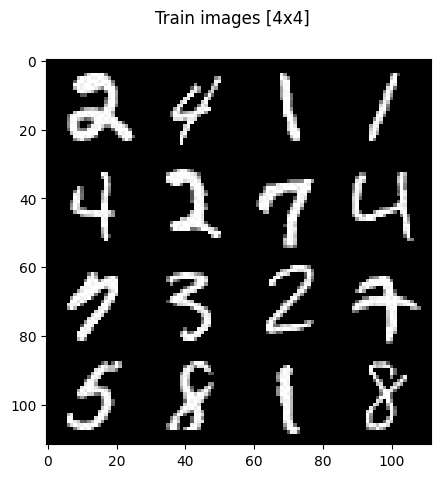

In [22]:
# defining global path variables
MODEL_DIR = "./saved_models"
DATASET_PREFIX = "./data/MNIST"
DATA_PATH = f"{DATASET_PREFIX}/raw/mnist_dataset.csv"


# Load the train, validation and test sets. Get a batch of 16 images for each set.
train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=16)
train_images, train_labels = next(iter(train_dl))
test_images, test_labels = next(iter(test_dl))

# Display the batches using the previously defined `show_batch` function
# Show train batch with title "Train images"
show_batch(train_images, title="Train images", cols=4)
print(train_labels)